In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

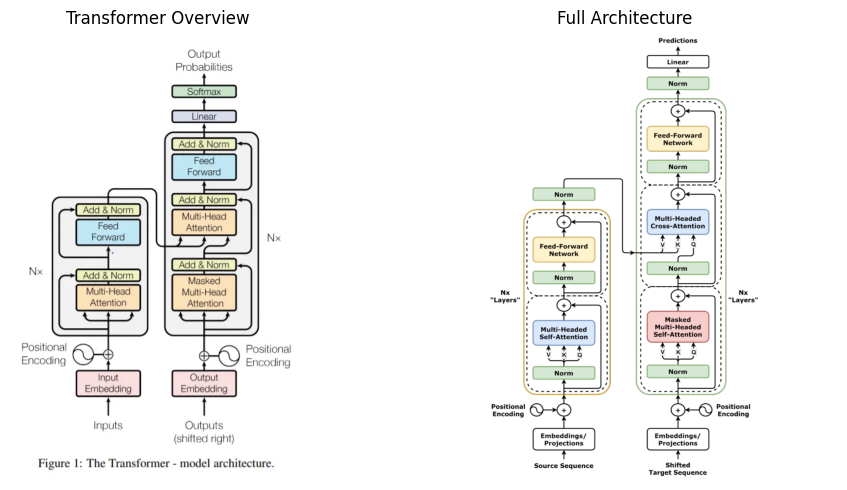

In [46]:


img = Image.open("Transformer.webp")
img1 = Image.open("Transformer,_full_architecture.png")

plt.figure(figsize=(10, 5))  

# First image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Transformer Overview")

# Second image
plt.subplot(1, 2, 2)
plt.imshow(img1)
plt.axis('off')
plt.title("Full Architecture")

plt.tight_layout()
plt.show()

In [47]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,# vocabulary size
    "context_length": 1024,# context length 
    "emb_dim":768,# Embedding dimension 
    "n_heads":12,#Number of attentiion heads
    "n_layers":12,#Number of layers
    "drop_rate":0.1,#Dropout rate
    "qkv_bias":False,# Query-key-value bias
    "training":False

}

In [48]:
from tensorflow.keras import layers

In [49]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,cfg):
        super(TransformerBlock,self).__init__()
        self.cfg = cfg
        #LayerNorm1
        self.layer_norm1 = layers.LayerNormalization(axis=-1,epsilon=0.0001,center = True,scale=True)
        # DropoutLayer
        self.dropout_layer = layers.Dropout(self.cfg["drop_rate"])
        #MultiHeadAttention
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=cfg["n_heads"],dropout=self.cfg["drop_rate"],output_shape=cfg["emb_dim"],key_dim=64,value_dim=64)
        #LayerNorm2
        self.layer_norm2 = layers.LayerNormalization(axis=-1,epsilon=1e-4,center = True,scale=True)
        # FeedforwardNetwork
        self.feed_forward_network = tf.keras.models.Sequential([layers.Dense(units=4*self.cfg['emb_dim'],activation='gelu'),
                                                                layers.Dense(units=self.cfg["emb_dim"])])  

    def call(self,x):
        x0 = x
        x1 = self.layer_norm1(x)
        x2 = self.multi_head_attention(x1,x1)
        x2 = self.dropout_layer(x2,training=self.cfg["training"])
        x3 = x2 + x0  # residual or shortcut
        
        x4 = self.layer_norm2(x3)
        x5 = self.feed_forward_network(x4)
        x5 = self.dropout_layer(x5,training=self.cfg['training'])
        x6 = x5 + x3

        return x6  # logits
        


In [44]:
block = TransformerBlock(GPT_CONFIG_124M)
dummy_input = tf.random.uniform((1, 10, GPT_CONFIG_124M["emb_dim"]))
_ = block(dummy_input)

for var in block.trainable_variables:
    print(var.name, var.shape)

gamma (768,)
beta (768,)
kernel (768, 12, 64)
bias (12, 64)
kernel (768, 12, 64)
bias (12, 64)
kernel (768, 12, 64)
bias (12, 64)
kernel (12, 64, 768)
bias (768,)
gamma (768,)
beta (768,)
kernel (768, 3072)
bias (3072,)
kernel (3072, 768)
bias (768,)


In [26]:
# GPT 2 Model 

In [ ]:
class GPT2(tf.keras.models.Model):
    def __init__(self,cfg):
        super(GPT2,self).__init__()
        self.cfg = cfg
        self.embedding = layers.Embedding(input_dim=cfg["vocab_size"],output_dim=cfg["emb_dim"])
        self.pos_emb = layers.Embedding(input_dim=cfg["context_length"],output_dim=cfg['emb_dim'])
        self.drop_emb = layers.Dropout(cfg["drop_rate"])

        self.trf_blocs = tf.keras.models.Sequential(
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = layers.LayerNormalization(axis=-1,epsilon=1e-4,center = True,scale=True)
        
        self.out_head = layers.Dense(units=cfg["vocab_size"])

    def call(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.embedding(in_idx)
        pos_embeds = self.pos_emb(tf.range(seq_len, dtype=in_idx.dtype))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocs(x)
        x = self.final_norm(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits





In [54]:
gpt2 = GPT2(GPT_CONFIG_124M)

TypeError: Sequential.__init__() takes from 1 to 4 positional arguments but 13 were given

In [55]:
for name, param in model.named_parameters():
    print(name, param.shape)

NameError: name 'model' is not defined

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model.summary()  # Prints a full layer-wise summary
print(model.count_params())  # Total number of parameters

In [ ]:
model.get_params()  # Returns a dictionary of hyperparameters